# **Trabajo Práctico N°1 : Reservas de Hotel**

**Checkpoint 2**

Grupo: N°06 - Pandatos

Integrantes: 
* Juan Sebastian Makkos 
* Valeria Brzoza 
* Rodolfo Valentin Albornoz Tomé.


Importamos las librerias correspondientes que vamos a utilizar

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer

from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('always')

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


Cargamos el dataset de hotels_train y de hotels_test


In [3]:
ds_hotels_train = pd.read_csv('/content/drive/MyDrive/TP1_Orga/ds_trabajo_procesado.csv')
ds_trabajo = ds_hotels_train.copy()
ds_hotels_test = pd.read_csv('/content/drive/MyDrive/TP1_Orga/hotels_test.csv')
ds_test = ds_hotels_test.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Sacamos del dataset de test las columnas eliminadas en el dataset de trabajo debido al análisis exploratorio

In [4]:
ds_test = ds_test[['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'total_of_special_requests', 'id']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Construcción de árboles de decisión y optimización de hiperparámetros**

Guardamos una copia de la columna id del dataset de test y luego la eliminamos del mismo dataset para evitar errores

In [5]:
ds_test_id = ds_test['id'].copy()
ds_test = ds_test.drop(['id'], axis='columns', inplace=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Eliminamos las columnas Unnamed: 0 y id ya que no los necesitamos en el dataset de train



In [6]:
ds_trabajo = ds_trabajo.drop(['Unnamed: 0'], axis='columns', inplace=False)
ds_trabajo = ds_trabajo.drop(['id'], axis='columns', inplace=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Categorizamos todas las variables categoricas con label encoder tanto en el dataset de test como el de train

In [7]:
variables_categoricas = ['hotel', 'arrival_date_year', 'arrival_date_month', 
                         'arrival_date_day_of_month', 'meal', 'country',
                         'is_repeated_guest', 'reserved_room_type', 
                         'assigned_room_type', 'deposit_type', 'agent', 
                         'customer_type']

label_encoder = preprocessing.LabelEncoder()

for columna in ds_trabajo.columns:
  if columna in variables_categoricas:
    ds_trabajo[columna] = label_encoder.fit_transform(ds_trabajo[columna]) 
for columna in ds_test.columns:
  if columna in variables_categoricas:
    ds_test[columna] = label_encoder.fit_transform(ds_test[columna])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Realizamos la división del dataset de trabajo en train y test, donde nuestro target es la columna is_canceled, dividiendo train y test en proporción 70/30

In [8]:
target = 'is_canceled'

ds_trabajo_y = ds_trabajo[target].copy()
ds_trabajo_x=ds_trabajo.drop([target], axis='columns', inplace=False)

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, 
                                                    ds_trabajo_y, 
                                                    test_size = 0.3,  
                                                    random_state = 109)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Configuración de hiperparámetros

Realizamos la optimizacion de hiperparametros con cross validation para obtener la mejor performance. Utilizamos la metrica f1_score, ya que veiamos que era la mejor para sacar el mejor valor, y luego utilizamos una cantidad de combinaciones n = 30 y una cantidad de folds = 5

In [9]:
n = 30

params_grid = {'criterion': ['entropy','gini'],
               'ccp_alpha': np.linspace(0,0.00001,n), 
               'max_depth': list(range(1,15))}

folds = 5

kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier() 

scorer_fn = make_scorer(sk.metrics.f1_score)

randomcv = RandomizedSearchCV(estimator = base_tree,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n) 

randomcv.fit(x_train,y_train);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ahora modelamos árboles con distintas caracteristicas, como el tipo de criterio (Gini, entropy) o si tiene poda o no. Entrenamos cada arbol, y se saca la predicción con el dataset de test.

### Arbol con criterio entropy sin poda

Creamos un arbol donde el criterio es entropy y no tiene poda

In [10]:
tree_model_entropy_sin_poda = tree.DecisionTreeClassifier(criterion = 'entropy',
                                                          max_depth = 10, 
                                                          min_samples_leaf = 10) 

model_entropy_sin_poda = tree_model_entropy_sin_poda.fit(X = x_train, y = y_train)

y_pred_entropy_sin_poda = model_entropy_sin_poda.predict(x_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Imprimimos el valor de cada métrica para ver qué tan bueno es el arbol


In [11]:
print("f1_score: " + str(f1_score(y_test, y_pred_entropy_sin_poda)))
print("Accuracy: " + str(accuracy_score(y_test, y_pred_entropy_sin_poda)))
print("Recall: " + str(recall_score(y_test,y_pred_entropy_sin_poda)))
print("Precision: " + str(precision_score(y_test,y_pred_entropy_sin_poda)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


f1_score: 0.8213498540537321
Accuracy: 0.8140962062980411
Recall: 0.8188620976362988
Precision: 0.8238527724665392


### Arbol con criterio gini sin poda

Ahora creamos otro arbol pero con criterio gini, y sin poda

In [12]:
tree_model_gini_sin_poda = tree.DecisionTreeClassifier(criterion = "gini", 
                                                       max_depth = 10, 
                                                       min_samples_leaf = 10) 

model_gini_sin_poda = tree_model_gini_sin_poda.fit(X = x_train, y = y_train)

y_pred_gini_sin_poda = model_gini_sin_poda.predict(x_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Imprimimos el valor de cada métrica para ver qué tan bueno es el arbol

In [13]:
print("f1_score: " + str(f1_score(y_test, y_pred_gini_sin_poda)))
print("Accuracy: " + str(accuracy_score(y_test, y_pred_gini_sin_poda)))
print("Recall: " + str(recall_score(y_test,y_pred_gini_sin_poda)))
print("Precision: " + str(precision_score(y_test,y_pred_gini_sin_poda)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


f1_score: 0.8355530151471849
Accuracy: 0.8216588147780808
Recall: 0.8681553628696995
Precision: 0.8053107095636844


### Arbol con criterio entropy con poda

Ahora vamos a armar el arbol pero con poda, primero con criterio de entropy


In [14]:
tree_model_entropy_con_poda = tree.DecisionTreeClassifier(criterion = "entropy",
                                                          max_depth = 14, 
                                                          min_samples_leaf = 10, 
                                                          ccp_alpha = 3.103448275862069e-06)

model_entropy_con_poda = tree_model_entropy_con_poda.fit(X = x_train, y = y_train)

y_pred_entropy_con_poda = model_entropy_con_poda.predict(x_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Imprimimos el valor de cada métrica para ver qué tan bueno es el arbol

In [15]:
print("f1_score: " + str(f1_score(y_test, y_pred_entropy_con_poda)))
print("Accuracy: " + str(accuracy_score(y_test, y_pred_entropy_con_poda)))
print("Recall: " + str(recall_score(y_test,y_pred_entropy_con_poda)))
print("Precision: " + str(precision_score(y_test,y_pred_entropy_con_poda)))

f1_score: 0.8416258287690978
Accuracy: 0.82971733201091
Recall: 0.866967573346003
Precision: 0.8177235043692583


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Arbol con criterio gini con poda

Ahora armamos el arbol con poda y criterio de gini

In [16]:
tree_model_gini_con_poda = tree.DecisionTreeClassifier(criterion = "gini",
                                                       max_depth = 10, 
                                                       min_samples_leaf = 10, 
                                                       ccp_alpha = 0.01)

model_gini_con_poda = tree_model_gini_con_poda.fit(X = x_train, y = y_train)

y_pred_gini_con_poda = model_gini_con_poda.predict(x_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Imprimimos el valor de cada métrica para ver qué tan bueno es el arbol

In [17]:
print("f1_score: " + str(f1_score(y_test, y_pred_gini_con_poda)))
print("Accuracy: " + str(accuracy_score(y_test, y_pred_gini_con_poda)))
print("Recall: " + str(recall_score(y_test,y_pred_gini_con_poda)))
print("Precision: " + str(precision_score(y_test,y_pred_gini_con_poda)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


f1_score: 0.7688333533581642
Accuracy: 0.7614678899082569
Recall: 0.760066516213327
Precision: 0.7778047891090313


# **Análisis del arbol de mejor performance**

Realizando el análisis de cada tipo de arbol, llegamos a que el arbol con mejor performance con la métrica f1_score era aquel con criterio entropy y con poda

Veamos qué pasa con la métrica f1_score si entrenamos el mismo arbol con diferentes conjuntos de datos (En este caso, con cada split de un cv)

In [18]:
resultados = cross_validate(tree_model_entropy_con_poda, x_train, y_train, cv = kfoldcv, 
                            scoring = scorer_fn, return_estimator = True)

metricsCV = resultados['test_score']
mejor_performance = resultados['estimator'][np.where(metricsCV == max(metricsCV))[0][0]]
metricsCV

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.83480454, 0.84369996, 0.84294037, 0.83751254, 0.83893628])

Realizamos un boxplot de los valores que toma la métrica f1_score para cada conjunto de datos distinto

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

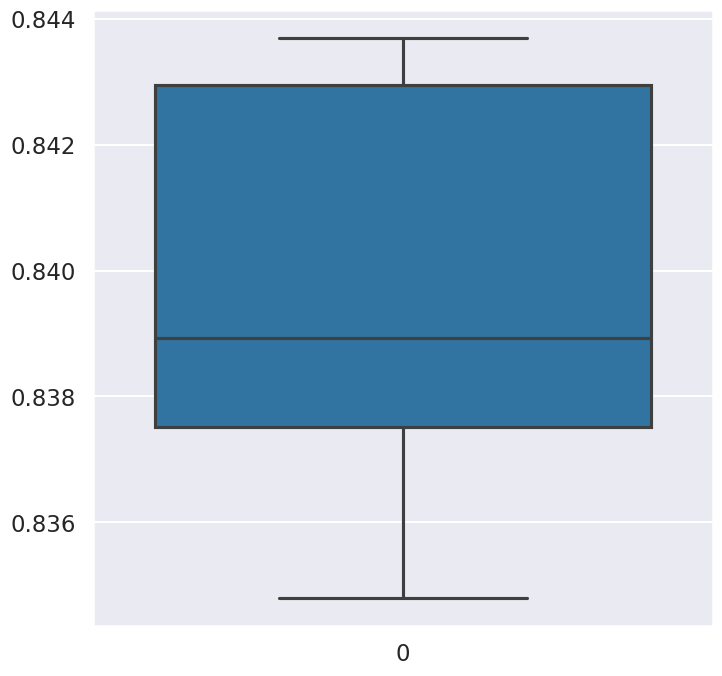

In [19]:
metric_labelsCV = ['F1 Score']*len(metricsCV) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(metricsCV)

Graficamos el arbol poniendo una máxima profundidad de 3

In [20]:
model_entropy_con_poda.classes_

plt.figure(figsize=(100,100))

tree_plot = tree.plot_tree(model_entropy_con_poda,
                           max_depth = 2,
                           feature_names = ds_trabajo_x.columns.to_list(),
                           filled = True,
                           rounded = True, 
                           class_names = True)

plt.show(tree_plot)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Viendo el gráfico, se pueden observar las siguientes reglas:
1. Se analiza primero el tipo de depósito. Si no hay depósito, se analiza por la cantidad de cancelaciones previas. En tal caso, si no hay cancelaciones previas, se analiza por lead_time. Y si hay cancelaciones previas, se analiza por previous_bookings_not_canceled.

2. Si hay depósito (Non Refund o Refundable), se analiza por el pais. Para ciertos paises, se analiza por customer_type, y para otros, por agent.

Calculamos la importancia de gini de cada atributo

In [21]:
sorted(list(zip(ds_trabajo_x.columns.to_list(), model_entropy_con_poda.feature_importances_)), key=lambda x: -x[1])

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('deposit_type', 0.2934765453613649),
 ('agent', 0.20562766655278947),
 ('lead_time', 0.0868409255947017),
 ('customer_type', 0.07201041706610375),
 ('total_of_special_requests', 0.06698510976605752),
 ('country', 0.05462486750699473),
 ('previous_cancellations', 0.04938200235612494),
 ('arrival_date_year', 0.04546749923370227),
 ('adr', 0.027770834694823162),
 ('arrival_date_month', 0.019112303824573598),
 ('arrival_date_day_of_month', 0.017852033196364043),
 ('booking_changes', 0.014361587851347253),
 ('stays_in_week_nights', 0.008528598410262258),
 ('assigned_room_type', 0.008521236455616598),
 ('stays_in_weekend_nights', 0.007880256041443663),
 ('reserved_room_type', 0.006416599821331853),
 ('previous_bookings_not_canceled', 0.006144437119543562),
 ('days_in_waiting_list', 0.002470662253291274),
 ('hotel', 0.001672742788015249),
 ('is_repeated_guest', 0.0014694917149401143),
 ('meal', 0.001463939935064823),
 ('children', 0.0010671244726270892),
 ('adults', 0.0008531179829161189),


Vemos que los atributos de mayor importancia parecen ser el tipo de depósito y agent

Imprimimos cuáles son los mejores hiperparámetros encontrados, y cuál es el mejor valor de la métrica f1_score

In [22]:
for param, valor in randomcv.best_params_.items():
    print(f'{param} -> {valor}')

print(randomcv.best_score_)

max_depth -> 14
criterion -> entropy
ccp_alpha -> 6.896551724137932e-06
0.8401252122669686


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Esto nos llevó a crear un arbol con máxima profundidad 14, con criterio entropy y se determinó que era mejor realizar poda al arbol

Creamos y graficamos la matriz de confusión

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(34.08333333333333, 0.5, 'Real')

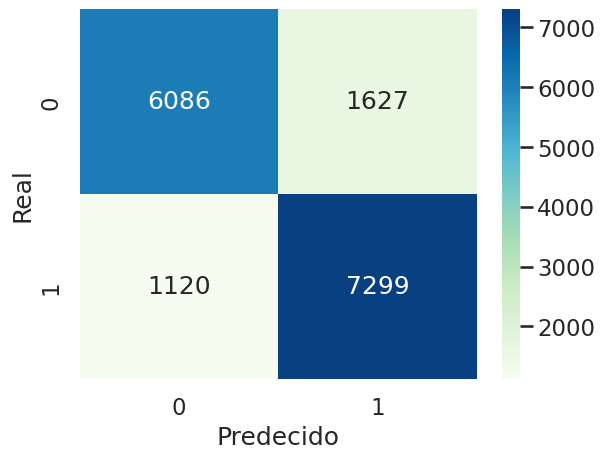

In [23]:
tabla = confusion_matrix(y_test, y_pred_entropy_con_poda)

sns.heatmap(tabla, cmap ='GnBu', annot = True, fmt = 'g')
plt.xlabel("Predecido")
plt.ylabel("Real")

Analizamos el valor de las métricas para el conjunto de test

In [24]:
print(classification_report(y_test, y_pred_entropy_con_poda))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82      7713
           1       0.82      0.87      0.84      8419

    accuracy                           0.83     16132
   macro avg       0.83      0.83      0.83     16132
weighted avg       0.83      0.83      0.83     16132



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Y ahora para el conjunto de entrenamiento

In [25]:
print(classification_report(y_train, model_entropy_con_poda.predict(x_train)))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84     18017
           1       0.84      0.89      0.87     19622

    accuracy                           0.86     37639
   macro avg       0.86      0.85      0.86     37639
weighted avg       0.86      0.86      0.86     37639



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Viendo el valor de las métricas para cada conjunto de datos, y con la matriz de confusión, podemos decir que, entre los label 0 y 1, no hay una clara diferencia entre ambos. 

Tambien coincide que en ambos casos, para el conjunto de entrenamiento como para el conjunto de test, el label 1 es el que tiene mayor valor para recall y f1-score y coincide con la mayor cantidad de registros con este label.

Por ultimo, como podemos observar, el F1-score en datos de entrenamiento es similar al F1-score con datos nuevos de testeo, esto es un buen indicio que el modelo no esta overfiteado.

# **Submission y exportación del modelo entrenado**

Exportamos el modelo del arbol entrenado con mejor performance

In [26]:
import joblib

joblib.dump(model_entropy_con_poda, 'clasificador_arbolEntropyPoda.joblib')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['clasificador_arbolEntropyPoda.joblib']

Se saca la prediccion con el dataset Test y posteriormente, se guarda la submisión para la subida a Kaggle

In [27]:
y_pred_poda_entropy = model_entropy_con_poda.predict(ds_test)

df_submission = pd.DataFrame({'id': ds_test_id, target: y_pred_poda_entropy})

df_submission.to_csv('/content/drive/MyDrive/TP1_Orga/submissions/submission_poda_entropy.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
